<a href="https://colab.research.google.com/github/GeorgeShmelin/Masterschool_time_series_Project_supermarket_favorita/blob/main/4_time_series_prophet_model_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prophet doesn’t learn patterns based on IDs, even if they’re integers. It treats all extra columns as numeric features with real-world meaning (e.g., temperature, price, promotions). So passing store_nbr or item_nbr as integers will confuse the model — it will try to learn that higher store/item IDs cause more sales, which is meaningless.
Therefore, only for this prophet model I choosing only 1 most popular Favorita supermarket and modeling daily transactions vs weekday, holidays, oil price, etc

# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from prophet.plot import plot_plotly

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from prophet import Prophet

In [6]:
import os
import joblib
import gc

# Data download

https://github.com/GeorgeShmelin/Masterschool_time_series_Project_supermarket_favorita.git

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
df_download = pd.read_csv('/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train_4.csv')
df_download.shape

<ipython-input-8-d524008b3340>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_download = pd.read_csv('/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train_4.csv')


(86153, 8)

In [9]:
df_download.sample(2)

,item_nbr,onpromotion,dcoilwtico,transferred,transactions,date,is_holiday,weighted_unit_sales
1603,1109389,0,44.58,0,3563,2015-09-15,0,26.0
668,1463862,0,44.58,0,3563,2015-09-15,0,73.0


In [10]:
df_download['date'] = pd.to_datetime(df_download['date'])

In [11]:
df_download.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86153 entries, 0 to 86152
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   item_nbr             86153 non-null  int64         
 1   onpromotion          86153 non-null  int64         
 2   dcoilwtico           61830 non-null  float64       
 3   transferred          86153 non-null  int64         
 4   transactions         86153 non-null  int64         
 5   date                 41645 non-null  datetime64[ns]
 6   is_holiday           86153 non-null  int64         
 7   weighted_unit_sales  86153 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(5)
memory usage: 5.3 MB


In [12]:
# Downcast numeric columns and preserve datetime efficiently
for col in df_download.columns:
    if pd.api.types.is_integer_dtype(df_download[col]):
        df_download[col] = pd.to_numeric(df_download[col], downcast='integer')
    elif pd.api.types.is_float_dtype(df_download[col]):
        df_download[col] = pd.to_numeric(df_download[col], downcast='float')
    elif pd.api.types.is_datetime64_any_dtype(df_download[col]):
        # Leave datetime as-is; already efficient in pandas
        continue



---
# Data Transformation



In [13]:
df_in = df_download.copy()

In [14]:
df_daily = df_in.groupby('date').agg({
    'transactions': 'sum',
    'onpromotion': 'sum',
    'weighted_unit_sales': 'sum',
    'is_holiday': 'max',       # 1 if any row that day is a holiday
    'transferred': 'max',     # 1 if any row says holiday was transferred
    'dcoilwtico': 'mean'       # Oil price averaged over day if multiple values
}).reset_index()

In [15]:
df_daily.sample(5)

,date,transactions,onpromotion,weighted_unit_sales,is_holiday,transferred,dcoilwtico
2,2015-09-17,13198589,59,60778.984375,0,0,46.930000
12,2015-09-27,3965976,21,24664.468750,0,0,NaN
13,2015-09-28,2475576,15,14639.938477,1,0,44.400002
11,2015-09-26,4085090,4,24303.564453,0,0,NaN
4,2015-09-19,19552232,59,119287.890625,0,0,NaN


based on my previous research, the oil price is the most influential factor on the amount of sales, but the effect of the oil price has a lag which varies (in different years) from 2 days till 3 weeks
https://github.com/GeorgeShmelin/Masterschool_time_series_Project_supermarket_favorita.git

In [16]:
df = df_daily.copy()

In [17]:
df['oil_lag3'] = df_daily['dcoilwtico'].shift(3)
del df['dcoilwtico']

In [18]:
df.sample(3)

,date,transactions,onpromotion,weighted_unit_sales,is_holiday,transferred,oil_lag3
4,2015-09-19,19552232,59,119287.890625,0,0,47.119999
13,2015-09-28,2475576,15,14639.938477,1,0,45.549999
10,2015-09-25,4115963,89,19681.166016,0,0,46.169998


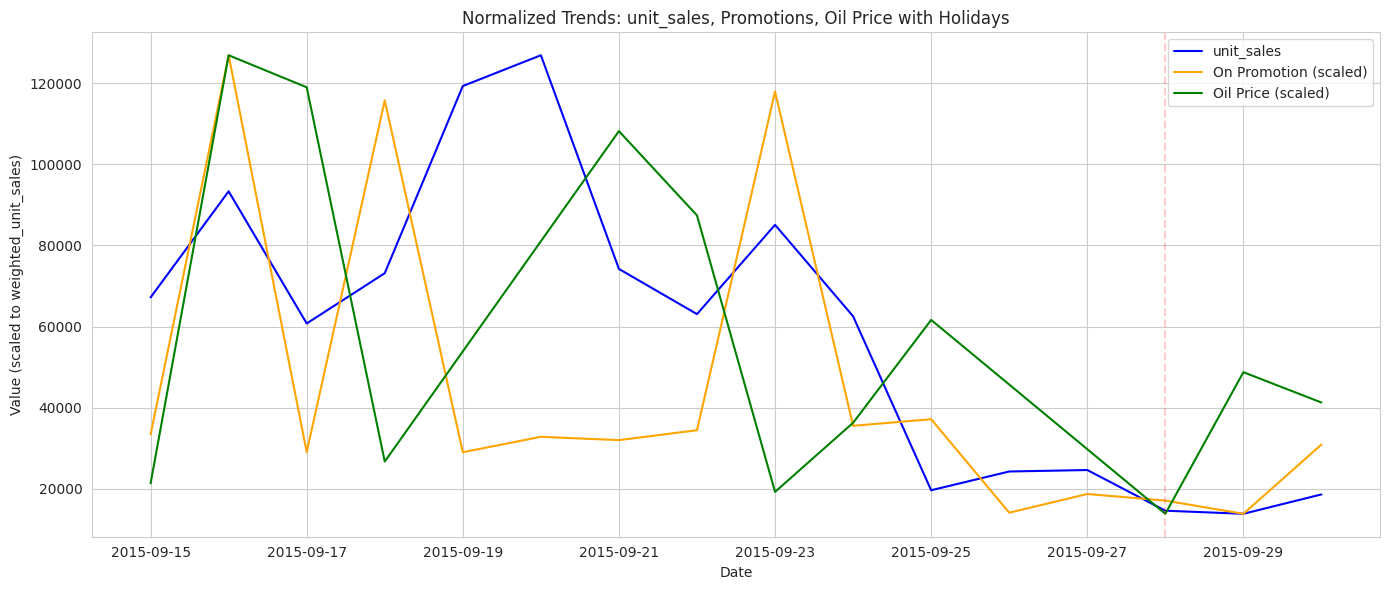

In [19]:
# Rescale function to match the transaction value range
def rescale_series(series, target_min, target_max):
    normalized = (series - series.min()) / (series.max() - series.min())
    return normalized * (target_max - target_min) + target_min

# Define transaction range
trans_min = df_daily['weighted_unit_sales'].min()
trans_max = df_daily['weighted_unit_sales'].max()

# Rescale oil price and onpromotion to transaction range
df_daily['oil_scaled'] = rescale_series(df_daily['dcoilwtico'], trans_min, trans_max)
df_daily['onpromotion_scaled'] = rescale_series(df_daily['onpromotion'], trans_min, trans_max)

# Plot
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')

# Transactions
sns.lineplot(data=df_daily, x='date', y='weighted_unit_sales', label='unit_sales', color='blue')

# Scaled promotions and oil price
sns.lineplot(data=df_daily, x='date', y='onpromotion_scaled', label='On Promotion (scaled)', color='orange')
sns.lineplot(data=df_daily, x='date', y='oil_scaled', label='Oil Price (scaled)', color='green')

# Highlight holidays
for holiday_date in df_daily[df_daily['is_holiday'] == 1]['date']:
    plt.axvline(holiday_date, color='red', linestyle='--', alpha=0.2)

# Labels and layout
plt.title('Normalized Trends: unit_sales, Promotions, Oil Price with Holidays')
plt.xlabel('Date')
plt.ylabel('Value (scaled to weighted_unit_sales)')
plt.legend()
plt.tight_layout()
plt.show()

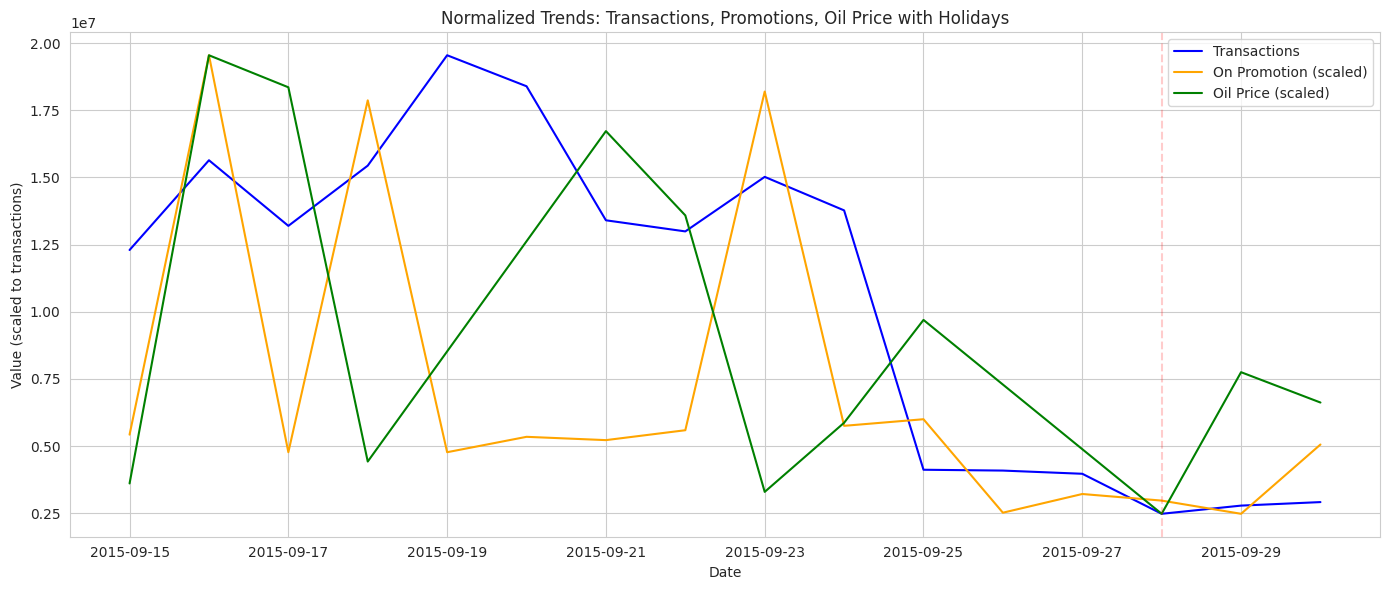

In [20]:
# Rescale function to match the transaction value range
def rescale_series(series, target_min, target_max):
    normalized = (series - series.min()) / (series.max() - series.min())
    return normalized * (target_max - target_min) + target_min

# Define transaction range
trans_min = df_daily['transactions'].min()
trans_max = df_daily['transactions'].max()

# Rescale oil price and onpromotion to transaction range
df_daily['oil_scaled'] = rescale_series(df_daily['dcoilwtico'], trans_min, trans_max)
df_daily['onpromotion_scaled'] = rescale_series(df_daily['onpromotion'], trans_min, trans_max)

# Plot
plt.figure(figsize=(14, 6))
sns.set_style('whitegrid')

# Transactions
sns.lineplot(data=df_daily, x='date', y='transactions', label='Transactions', color='blue')

# Scaled promotions and oil price
sns.lineplot(data=df_daily, x='date', y='onpromotion_scaled', label='On Promotion (scaled)', color='orange')
sns.lineplot(data=df_daily, x='date', y='oil_scaled', label='Oil Price (scaled)', color='green')

# Highlight holidays
for holiday_date in df_daily[df_daily['is_holiday'] == 1]['date']:
    plt.axvline(holiday_date, color='red', linestyle='--', alpha=0.2)

# Labels and layout
plt.title('Normalized Trends: Transactions, Promotions, Oil Price with Holidays')
plt.xlabel('Date')
plt.ylabel('Value (scaled to transactions)')
plt.legend()
plt.tight_layout()
plt.show()

### save my csv Prophet Data file in my Google Drive directory

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# file_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/df_train_4_prophet.csv'
# df.to_csv(file_path, index=False)



---
# Prophet Model


In [23]:
# Split 80% train, 20% test (random shuffle)
df_train, df_val = train_test_split(df_daily, test_size=0.2, random_state=42, shuffle=True)

In [24]:
df.sample(3)

,date,transactions,onpromotion,weighted_unit_sales,is_holiday,transferred,oil_lag3
4,2015-09-19,19552232,59,119287.890625,0,0,47.119999
5,2015-09-20,18397916,73,126870.859375,0,0,46.930000
12,2015-09-27,3965976,21,24664.468750,0,0,44.939999


### Prophet Setup

In [25]:
# Prepare training data for Prophet
df_train_prophet = df_train[['date', 'transactions']].rename(columns={'date': 'ds', 'transactions': 'y'})

# Build and fit model
model = Prophet()
model.fit(df_train_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkeix5day/9j3ou1dz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpkeix5day/we8iglt6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26932', 'data', 'file=/tmp/tmpkeix5day/9j3ou1dz.json', 'init=/tmp/tmpkeix5day/we8iglt6.json', 'output', 'file=/tmp/tmpkeix5day/prophet_model25nvfk4j/prophet_model-20250517130416.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:04:16 - cmdstanpy - INFO - Chain [1] start processing
IN

### Make Predictions

In [26]:
# Create future dataframe to include dates from df_val
future_dates = pd.DataFrame({'ds': pd.concat([df_train['date'], df_val['date']]).sort_values().drop_duplicates()})

# Predict
forecast = model.predict(future_dates)

### Plot Forecast

In [27]:
plot_plotly(model, forecast)

### Evaluate Accuracy on Validation

In [31]:
# Merge actual and predicted on validation dates
df_val_prophet = df_val[['date', 'transactions']].rename(columns={'date': 'ds', 'transactions': 'y'})
df_val_forecast = forecast[['ds', 'yhat']].merge(df_val_prophet, on='ds', how='inner')

# Calculate metrics
mae = mean_absolute_error(df_val_forecast['y'], df_val_forecast['yhat'])
# Calculate RMSE by taking the square root of the mean squared error
rmse = np.sqrt(mean_squared_error(df_val_forecast['y'], df_val_forecast['yhat']))
r2 = r2_score(df_val_forecast['y'], df_val_forecast['yhat'])

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.4f}")

MAE:  4047146.13
RMSE: 4950260.82
R²:   0.2947


## Save Prophet Model to Google Drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Save the trained model

In [34]:
# Define path
model_path = '/content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models/prophet_model.pkl'

# Save model
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

Model saved to: /content/drive/MyDrive/MasterSchool/MasterSchool_Python/Time_Series/Time_series_project/xgboost_models/prophet_model.pkl


To Load Later

In [35]:
# model = joblib.load(model_path)